In [16]:
from dask_gateway import Gateway
gateway = Gateway()
# cluster = GatewayCluster()
options = gateway.cluster_options()

options.worker_cores = 8 # 16 #16 / 4
options.worker_memory = 32 # 32 #32 / 8  

cluster = gateway.new_cluster(options)

cluster.adapt(minimum = 2, maximum = 150)

client = cluster.get_client() 
cluster

In [89]:
client.close()
cluster.close()

In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore") 

In [2]:
# get cm4 so and thetao data ('gn' without regriding)
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
col = open_catalog(url).climate.cmip6_gcs()

dslist = col.search(variable_id = ['so', 'thetao'], table_id = 'Omon', experiment_id = 'piControl', 
           source_id = 'GFDL-CM4', grid_label = 'gn')
ds = dslist['CMIP.NOAA-GFDL.GFDL-CM4.piControl.Omon.gn'].to_dask()
ds = ds.squeeze('member_id').reset_coords('member_id', drop = True)

In [3]:
import numpy as np
import xesmf as xe
import xarray as xr

import copy
import gsw

In [4]:
mldzscore = xr.open_dataset('mldzscore_cm4.nc').__xarray_dataarray_variable__

In [5]:
zs_weddell = mldzscore.sel(x = slice(-60, 30), y = slice(-90, -60)) 

In [6]:
zs_ross = mldzscore.sel(x = slice(-210, -135), y = slice(-90, -60)) 

In [7]:
convinx_weddell = xr.open_dataset('convinx_weddell_cm4.nc').thetao * -1

In [45]:
convinx_ross = xr.open_dataset('convinx_ross_cm4.nc').thetao * -1

In [8]:
temp_weddell = ds.thetao.where(zs_weddell>2)
sali_weddell = ds.so.where(zs_weddell>2)
temp_ross = ds.thetao.where(zs_ross>2)
sali_ross = ds.so.where(zs_ross>2)

In [8]:
### modeified from: https://teos-10.github.io/GSW-Python/_modules/gsw/stability.html#Nsquared
def calculate_n2(t, s):
    p = gsw.p_from_z(-s.lev, s.lat)
    sa = gsw.SA_from_SP(s, p, s.lon, s.lat)
    ct = gsw.CT_from_t(sa, t, p)
    
    sa_shallow = sa.isel(lev = slice(0, -1))
    sa_deep = sa.isel(lev = slice(1, None))
    
    ct_shallow = ct.isel(lev = slice(0, -1))
    ct_deep = ct.isel(lev = slice(1, None))
    
    p_shallow = p.isel(lev = slice(0, -1))
    p_deep = p.isel(lev = slice(1, None))
    
    lev_mid = (sa_shallow.lev.values + sa_deep.lev.values) * 0.5
    
    sa_shallow = sa_shallow.assign_coords(lev = lev_mid)
    sa_deep = sa_deep.assign_coords(lev = lev_mid)
    
    ct_shallow = ct_shallow.assign_coords(lev = lev_mid)
    ct_deep = ct_deep.assign_coords(lev = lev_mid)
    
    p_shallow = p_shallow.assign_coords(lev = lev_mid)
    p_deep = p_deep.assign_coords(lev = lev_mid)
    
    db_to_pa = 1e4
    p_mid = gsw.p_from_z(-sa_shallow.lev, sa_shallow.lat)
    
    g = gsw.grav(sa_shallow.lat, p_mid)
    g_local = g

    dSA = sa_deep - sa_shallow
    dCT = ct_deep - ct_shallow
    dp = p_deep - p_shallow
    
    SA_mid = 0.5 * (sa_deep + sa_shallow)
    CT_mid = 0.5 * (ct_deep + ct_shallow)
    p_mid = 0.5 * (p_deep + p_shallow)
       
    specvol_mid = gsw.specvol(SA_mid, CT_mid, p_mid)
    alpha_mid = gsw.alpha(SA_mid, CT_mid, p_mid)
    beta_mid = gsw.beta(SA_mid, CT_mid, p_mid)

    N2 = ((g_local**2) / (specvol_mid * db_to_pa * dp))
    N2 *= (beta_mid*dSA - alpha_mid*dCT)
    return N2


In [9]:
### according to the defination

# functions for calculating potential density (dens0)
def smow(t):
    a = (999.842594, 6.793952e-2, -9.095290e-3, 1.001685e-4, -1.120083e-6,
         6.536332e-9)
    T68 = t * 1.00024
    return (a[0] + (a[1] + (a[2] + (a[3] + (a[4] + a[5] * T68) * T68) * T68) *
            T68) * T68)

def dens0(s, t):
    T68 = t * 1.00024
    b = (8.24493e-1, -4.0899e-3, 7.6438e-5, -8.2467e-7, 5.3875e-9)
    c = (-5.72466e-3, 1.0227e-4, -1.6546e-6)
    d = 4.8314e-4
    return (smow(t) + (b[0] + (b[1] + (b[2] + (b[3] + b[4] * T68) * T68) *
            T68) * T68) * s + (c[0] + (c[1] + c[2] * T68) * T68) * s *
            s ** 0.5 + d * s ** 2)

def calculate_n2_new(t, s):
    rho = dens0(s, t)
    drhodz = rho.differentiate('lev')
    N2 = 9.7963*drhodz/rho    
    return N2

In [10]:
n2_weddell_new = calculate_n2_new(temp_weddell, sali_weddell)

N2_weddell_ann_new = n2_weddell_new.groupby('time.year').mean('time')
N2_weddell_ann_new = N2_weddell_ann_new.mean('x').mean('y')

In [12]:
temp_weddell_sep = list(temp_weddell.groupby('time.month'))[8][-1]
sali_weddell_sep = list(sali_weddell.groupby('time.month'))[8][-1]

N2_weddell_sep_new = calculate_n2_new(temp_weddell_sep, sali_weddell_sep)
N2_weddell_sepn = N2_weddell_sep_new.mean('x').mean('y')

N2_weddell_sep_anm =  N2_weddell_sepn - N2_weddell_sepn.mean('time')

In [87]:
temp_weddell_sepavg = temp_weddell_sep.mean('time')
sali_weddell_sepavg = sali_weddell_sep.mean('time')

N2_weddell_avgtemp = calculate_n2_new(temp_weddell_sepavg, sali_weddell_sep)
N2_weddell_avgsali = calculate_n2_new(temp_weddell_sep, sali_weddell_sepavg)

N2_weddell_avgtemp_anm = N2_weddell_avgtemp - N2_weddell_sep_new
N2_weddell_avgt_anm = N2_weddell_avgtemp_anm.mean('x').mean('y')

N2_weddell_avgsali_anm = N2_weddell_avgsali - N2_weddell_sep_new
N2_weddell_avgs_anm = N2_weddell_avgsali_anm.mean('x').mean('y')

In [14]:
temp_ross_sep = list(temp_ross.groupby('time.month'))[8][-1]
sali_ross_sep = list(sali_ross.groupby('time.month'))[8][-1]

N2_ross_sep_new = calculate_n2_new(temp_ross_sep, sali_ross_sep)
N2_ross_sepn = N2_ross_sep_new.mean('x').mean('y')

N2_ross_sep_anm =  N2_ross_sepn - N2_ross_sepn.mean('time')

In [41]:
temp_ross_sepavg = temp_ross_sep.mean('time')
sali_ross_sepavg = sali_ross_sep.mean('time')

N2_ross_avgtemp = calculate_n2_new(temp_ross_sepavg, sali_ross_sep)
N2_ross_avgsali = calculate_n2_new(temp_ross_sep, sali_ross_sepavg)

N2_ross_avgtemp_anm = N2_ross_avgtemp - N2_ross_sep_new
N2_ross_avgt_anm = N2_ross_avgtemp_anm.mean('x').mean('y')

N2_ross_avgsali_anm = N2_ross_avgsali - N2_ross_sep_new
N2_ross_avgs_anm = N2_ross_avgsali_anm.mean('x').mean('y')

In [88]:
N2_weddell_sep_anm = N2_weddell_sep_anm.load()

KeyboardInterrupt: 

In [ ]:
N2_weddell_sepn = N2_weddell_sepn.load()

In [ ]:
N2_weddell_avgs_anm = N2_weddell_avgs_anm.load()

In [ ]:
N2_weddell_avgt_anm = N2_weddell_avgt_anm.load()

In [19]:
N2_ross_sep_anm = N2_ross_sep_anm.load()

In [42]:
N2_ross_avgt_anm = N2_ross_avgt_anm.load()

In [49]:
N2_ross_avgs_anm = N2_ross_avgs_anm.load()

In [52]:
N2_ross_sepn = N2_ross_sepn.load()

In [9]:
n2_weddell = calculate_n2(temp_weddell, sali_weddell)

In [10]:
N2_weddell_ann = n2_weddell.mean('x').mean('y').groupby('time.year').mean('time')
N2_weddell_sep = list(n2_weddell.mean('x').mean('y').groupby('time.month'))[8][-1]

In [30]:
n2_ross = calculate_n2(temp_ross, sali_ross)
N2_ross_ann = n2_ross.mean('x').mean('y').groupby('time.year').mean('time')
N2_ross_sep = list(n2_ross.mean('x').mean('y').groupby('time.month'))[8][-1]

In [22]:
N2_weddell_sep_new = N2_weddell_sep_new.load()

In [ ]:
n2_weddell_ann_new = n2_weddell_ann_new.load()

In [13]:
N2_weddell_ann = N2_weddell_ann.load()

In [22]:
N2_weddell_sep = N2_weddell_sep.load()

In [31]:
N2_ross_sep = N2_ross_sep.load()

In [18]:
import matplotlib.pyplot as plt

import matplotlib.colors as colors
import matplotlib.cbook as cbook

In [81]:
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

def filter_ds(ds, N):
    ds_rm = xr.apply_ufunc(
        runningMeanFast, 
        ds.chunk({"lev":-1, "time":-1}),  
        N,
        input_core_dims=[["lev"], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[ds.dtype])

In [82]:
N2_weddell_sep_anm_rm = filter_ds(N2_weddell_sep_anm, 30)

In [85]:
N2_weddell_sep_anm_rm

<xarray.DataArray (time: 500)>
dask.array<transpose, shape=(500,), dtype=float32, chunksize=(500,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0151-09-16 00:00:00 ... 0650-09-16 00:00:00

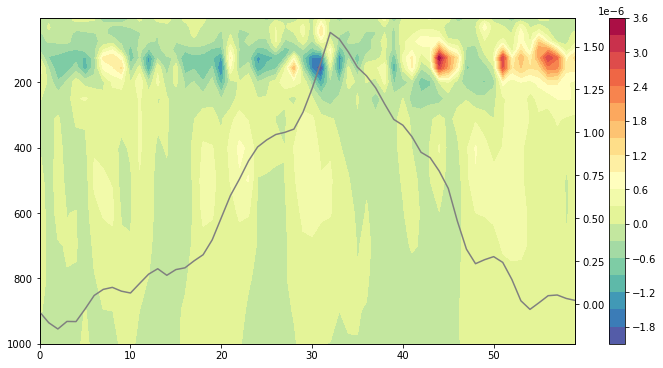

In [48]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

pltdata1 = N2_weddell_sep_anm.sel(lev = slice(0, 1000)).isel(time = slice(70,130))
pltdata2 = convinx_weddell.isel(year = slice(70,130))

im = ax1.contourf(np.arange(len(pltdata1.time)), pltdata1.lev, pltdata1.transpose(), 
                  levels = 20, cmap=plt.cm.Spectral_r)
                  # vmin=0, vmax=0.12)#, norm=colors.CenteredNorm()) #, norm=divnorm, 
plt.gca().invert_yaxis()
cbar = plt.colorbar(im)#, extend='none')

ax2 = ax1.twinx()
line, = ax2.plot(np.arange(len(pltdata1.time)), pltdata2, 'gray')
# ax2.set_ylabel('convection index')

KeyboardInterrupt: 

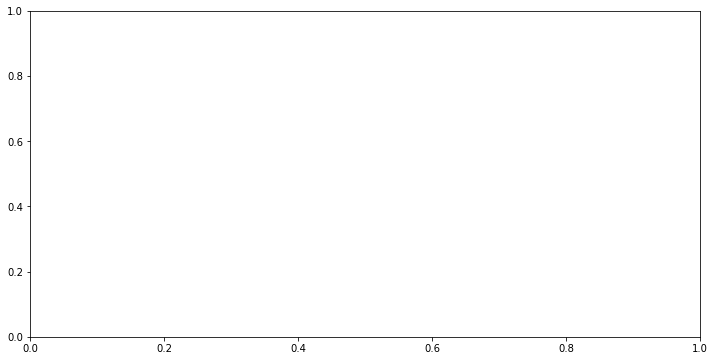

In [60]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

pltdata1 = runningMeanFast(N2_weddell_sep_anm.sel(lev = slice(0, 1000)).isel(time = slice(70,130)),30)
pltdata2 = runningMeanFast(convinx_weddell.isel(year = slice(70,130)), 30)

im = ax1.contourf(np.arange(len(pltdata1.time)), pltdata1.lev, pltdata1.transpose(), 
                  levels = 20, cmap=plt.cm.Spectral_r)
                  # vmin=0, vmax=0.12)#, norm=colors.CenteredNorm()) #, norm=divnorm, 
plt.gca().invert_yaxis()
cbar = plt.colorbar(im)#, extend='none')

ax2 = ax1.twinx()
line, = ax2.plot(np.arange(len(pltdata1.time)), pltdata2, 'gray')
# ax2.set_ylabel('convection index')

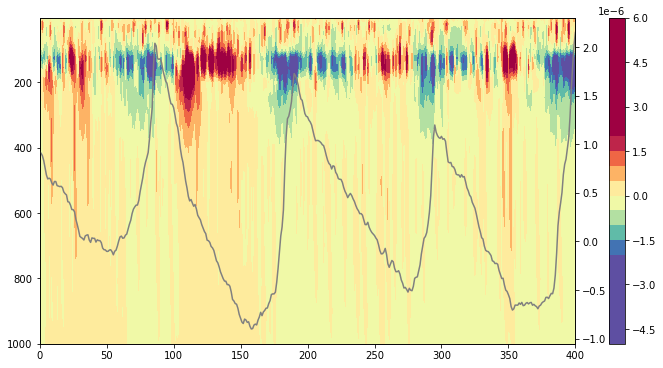

In [48]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

pltdata1 = N2_ross_sep_anm.sel(lev = slice(0, 1000)).isel(time = slice(None, 401))
pltdata2 = convinx_ross.isel(year = slice(None, 401))

im = ax1.contourf(np.arange(len(pltdata1.time)), pltdata1.lev, pltdata1.transpose(), 
                  cmap=plt.cm.Spectral_r, levels = 20, 
                  vmin=-0.000002, vmax=0.000002)#, norm=colors.CenteredNorm()) #, norm=divnorm, 
plt.gca().invert_yaxis()
cbar = plt.colorbar(im, extend='both')

ax2 = ax1.twinx()
line, = ax2.plot(np.arange(len(pltdata1.time)), pltdata2, 'gray')
# ax2.set_ylabel('convection index')

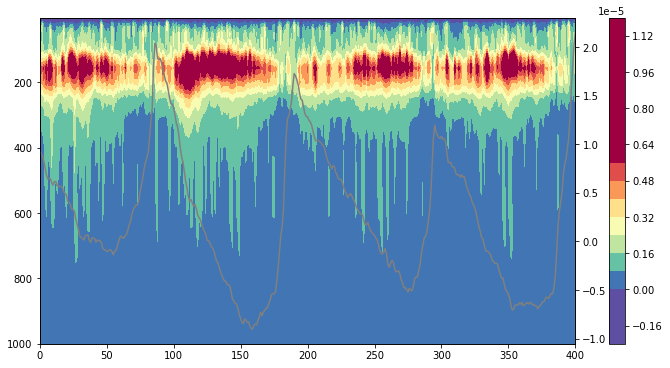

In [58]:


fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

pltdata1 = N2_ross_sepn.sel(lev = slice(0, 1000)).isel(time = slice(None, 401))
pltdata2 = convinx_ross.isel(year = slice(None, 401))

im = ax1.contourf(np.arange(len(pltdata1.time)), pltdata1.lev, pltdata1.transpose(), 
                  cmap=plt.cm.Spectral_r, levels = 20, 
                  vmin=0, vmax=0.000006)#, norm=colors.CenteredNorm()) #, norm=divnorm, 
plt.gca().invert_yaxis()
cbar = plt.colorbar(im, extend='both')

ax2 = ax1.twinx()
line, = ax2.plot(np.arange(len(pltdata1.time)), pltdata2, 'gray')
# ax2.set_ylabel('convection index')

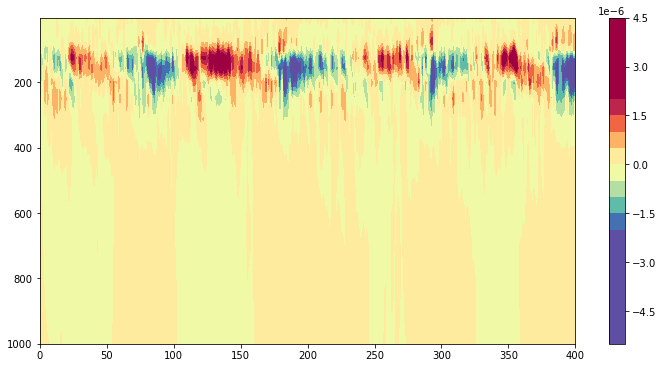

In [44]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

pltdata1 = N2_ross_avgt_anm.sel(lev = slice(0, 1000)).isel(time = slice(None, 401))

im = ax1.contourf(np.arange(len(pltdata1.time)), pltdata1.lev, pltdata1,#.transpose(), 
                  cmap=plt.cm.Spectral_r, levels = 20, 
                  vmin=-0.000002, vmax=0.000002)#, norm=colors.CenteredNorm()) #, norm=divnorm, 
plt.gca().invert_yaxis()
cbar = plt.colorbar(im, extend='both')

# ax2 = ax1.twinx()
# line, = ax2.plot(np.arange(len(pltdata1.time)), pltdata2, 'gray')
# ax2.set_ylabel('convection index')

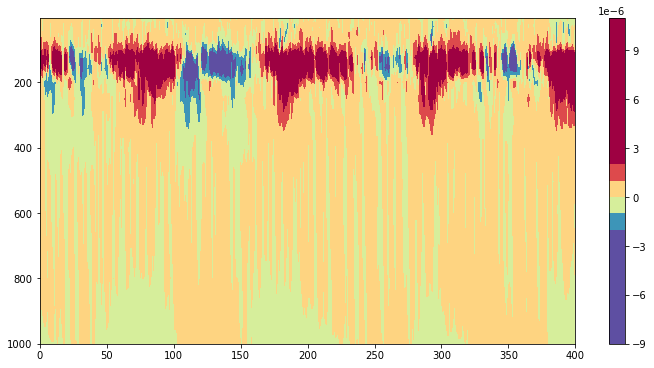

In [51]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111)

pltdata1 = N2_ross_avgs_anm.sel(lev = slice(0, 1000)).isel(time = slice(None, 401))

im = ax1.contourf(np.arange(len(pltdata1.time)), pltdata1.lev, pltdata1.transpose(), 
                  cmap=plt.cm.Spectral_r, levels = 20, 
                  vmin=-0.000002, vmax=0.000002)#, norm=colors.CenteredNorm()) #, norm=divnorm, 
plt.gca().invert_yaxis()
cbar = plt.colorbar(im, extend='both')

# ax2 = ax1.twinx()
# line, = ax2.plot(np.arange(len(pltdata1.time)), pltdata2, 'gray')
# ax2.set_ylabel('convection index')

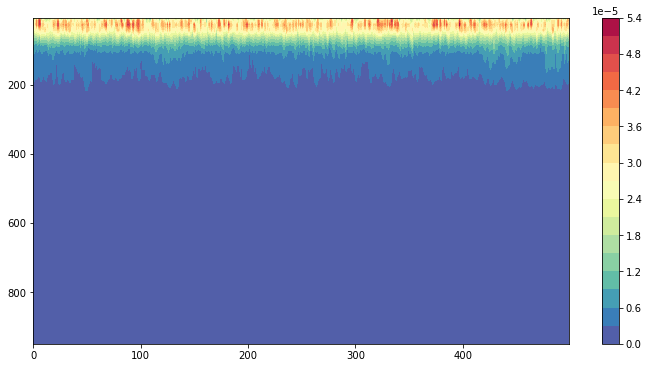

In [21]:
fig = plt.figure(figsize=(12,6))

pltdata1 = N2_weddell_ann.sel(lev = slice(0, 1000))

im = plt.contourf(np.arange(len(pltdata1.year)), pltdata1.lev, pltdata1, 
                  levels = 20, cmap=plt.cm.Spectral_r)
                  # vmin=0, vmax=0.12)#, norm=colors.CenteredNorm()) #, norm=divnorm, 
plt.gca().invert_yaxis()
cbar = plt.colorbar(im)#, extend='none')

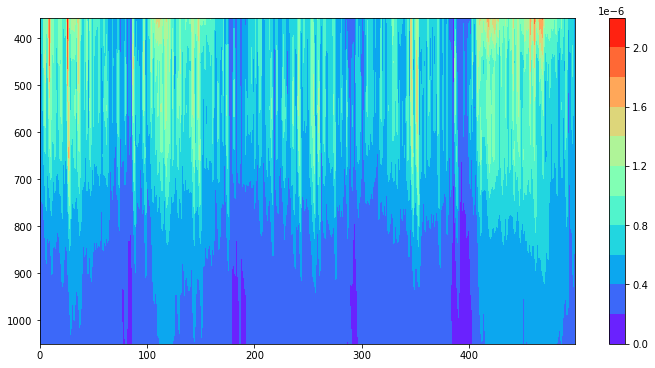

In [33]:
fig = plt.figure(figsize=(12,6))

pltdata1 = N2_ross_sep.sel(lev = slice(300, 1100))

im = plt.contourf(np.arange(len(pltdata1.time)), pltdata1.lev, pltdata1, 
                  levels = 10, cmap=plt.cm.rainbow)
                  # vmin=0, vmax=0.12)#, norm=colors.CenteredNorm()) #, norm=divnorm, 
plt.gca().invert_yaxis()
cbar = plt.colorbar(im)#, extend='none')

In [5]:
ds_ws0 = ds.sel(x = slice(-60, 30), y = slice(-90, -60))

In [6]:
ds_ws = ds_ws0.where(zs_weddell>2)

In [7]:
ds_gswp = gsw.p_from_z(-ds_ws.lev, ds_ws.lat)
ds_pbnds = gsw.p_from_z(-ds_ws.lev_bnds, ds_ws.lat)
ds_sa = gsw.SA_from_SP(ds_ws.so, ds_gswp, ds_ws.lon, ds_ws.lat)
ds_ct = gsw.CT_from_t(ds_sa, ds_ws.thetao, ds_gswp)

In [8]:
ds_sigma0 = gsw.sigma0(ds_sa, ds_ct)
ds_sigma1 = gsw.sigma1(ds_sa, ds_ct)
ds_sigma2 = gsw.sigma2(ds_sa, ds_ct)

In [9]:
ds_sigma0_new = gsw.pot_rho_t_exact(ds_sa, ds_ws.thetao, ds_gswp, 0)
ds_sigma1_new = gsw.pot_rho_t_exact(ds_sa, ds_ws.thetao, ds_gswp, 1000)
ds_sigma15_new = gsw.pot_rho_t_exact(ds_sa, ds_ws.thetao, ds_gswp, 1500)
ds_sigma2_new = gsw.pot_rho_t_exact(ds_sa, ds_ws.thetao, ds_gswp, 2000)

In [14]:
ds_sigma0_avg = ds_sigma0.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
ds_sigma1_avg = ds_sigma1.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
ds_sigma2_avg = ds_sigma2.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)

ds_sigma0_new_avg = ds_sigma0_new.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
ds_sigma1_new_avg = ds_sigma1_new.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
ds_sigma15_new_avg = ds_sigma15_new.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)
ds_sigma2_new_avg = ds_sigma2_new.groupby('time.year').mean(dim='time', skipna=True).mean(dim='x', skipna=True).mean(dim='y', skipna=True)

In [15]:
ds_sigma0_avg = ds_sigma0_avg.load()

In [16]:
ds_sigma1_avg = ds_sigma1_avg.load()

In [22]:
ds_sigma2_avg = ds_sigma2_avg.load()

In [23]:
ds_sigma0_new_avg = ds_sigma0_new_avg.load()

In [53]:
ds_sigma1_new_avg = ds_sigma1_new_avg.load()

In [27]:
ds_sigma15_new_avg = ds_sigma15_new_avg.load()

In [33]:
ds_sigma2_new_avg = ds_sigma2_new_avg.load()

In [1]:
import matplotlib.pyplot as plt

import matplotlib.colors as colors
import matplotlib.cbook as cbook

In [54]:
ds_sigma1_new_avg

<xarray.DataArray 'so' (year: 500, lev: 35)>
array([[1032.24952833, 1032.26835534, 1032.30652932, ..., 1032.61547991,
                  nan,           nan],
       [1032.34537901, 1032.35592319, 1032.37646705, ..., 1032.61525523,
                  nan,           nan],
       [1032.32959932, 1032.34109921, 1032.36404001, ..., 1032.61512976,
                  nan,           nan],
       ...,
       [1032.22525401, 1032.24230124, 1032.27587722, ..., 1032.55569944,
                  nan,           nan],
       [1032.22854425, 1032.25411686, 1032.29370782, ..., 1032.55564746,
                  nan,           nan],
       [1032.26757246, 1032.27875339, 1032.30592828, ..., 1032.55557424,
                  nan,           nan]])
Coordinates:
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
  * year     (year) int64 151 152 153 154 155 156 ... 645 646 647 648 649 650

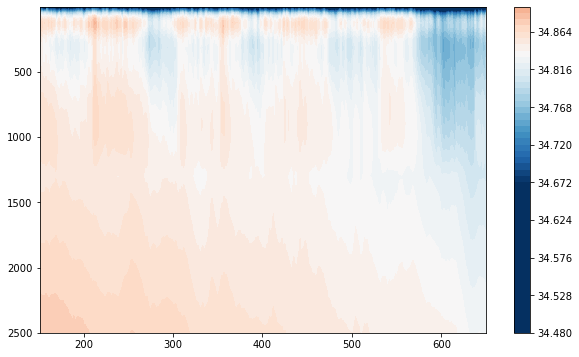

In [134]:
pltdata = ds_sigma15_new_avg - 1000
fig = plt.figure(figsize=(10,6))

levels = np.linspace(34.85, 35, 50)
pltdata = pltdata.sel(lev = slice(0, 2500))
im = plt.contourf(pltdata.year, pltdata.lev, pltdata.transpose(), levels = 50, vmin=34.67, vmax=35, cmap=plt.cm.RdBu_r)  #, norm=divnorm, 
plt.gca().invert_yaxis()
cbar = plt.colorbar(im, extend='both')

In [8]:
coninx_ws = xr.open_dataset('temp_weddellconv_cm4.nc').thetao.sel(lev = 2000, method = 'nearest').isel(year = slice(0,450))
coninx_ws = (coninx_ws - coninx_ws.mean('year'))/coninx_ws.std('year') * (-1)

In [9]:
coninx_rs = xr.open_dataset('temp_rossconv_cm4.nc').thetao.sel(lev = 2000, method = 'nearest').isel(year = slice(0,450))
coninx_rs = (coninx_rs - coninx_rs.mean('year'))/coninx_rs.std('year') * (-1)

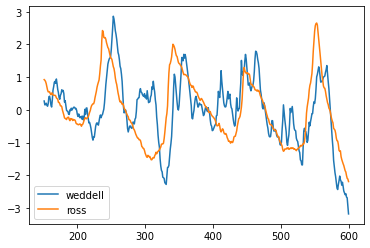

In [11]:
# fig = plt.figure(figsize=(8,6))

pltdata1 = coninx_ws
pltdata2 = coninx_rs
plt.plot(pltdata1.year, pltdata1) #, norm=divnorm, 
plt.plot(pltdata2.year, pltdata2)
plt.legend(['weddell','ross'])

In [12]:
def lag_cor(x,y,lag):
    stat=[]
    from scipy import stats
    for i in range(2*lag):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])
        stat.append(r_value)
    return stat

In [16]:
def lag_cor(x,y,lag, c, l):
    stat=[]
    from scipy import stats
    for i in range(2*lag):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])
        stat.append(r_value)
    x=np.linspace(-lag,lag+1, 2*lag)
    plt.grid(True,which="both",ls="-", color='0.65')
    plt.plot(x, stat, c, label=l, linewidth=3.0)
    plt.xlabel('Year lag')
    plt.ylabel('r')

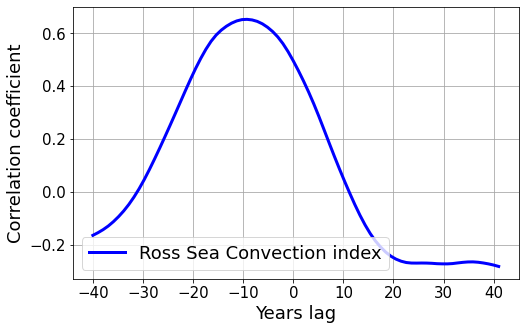

In [20]:
lag_time = 40

fig = plt.figure(figsize = (8,5))
lag_cor(coninx_ws, coninx_rs, lag_time,'b','Ross Sea Convection index')

''' !!!Problem need to be solved here !!!!'''
##### Q: Why -9 here? ######

plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 18)
# plt.title('Lagged correlation (Ross Sea Convection index), year {}-{}, {}'.format(start_year, end_year, model_name), fontsize=18)

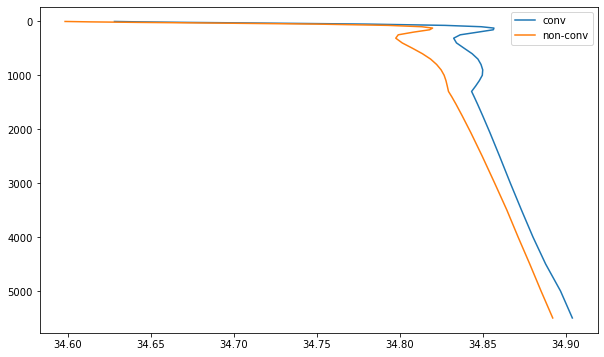

In [94]:
pltdata = ds_sigma15_new_avg - 1000
fig = plt.figure(figsize=(10,6))

pltdata1 = pltdata.where(coninx_ws>1).mean('year')
pltdata2 = pltdata.where(coninx_ws<-1).mean('year')
plt.plot(pltdata1, pltdata1.lev) #, norm=divnorm, 
plt.plot(pltdata2, pltdata2.lev)
plt.legend(['conv','non-conv'])
plt.gca().invert_yaxis()

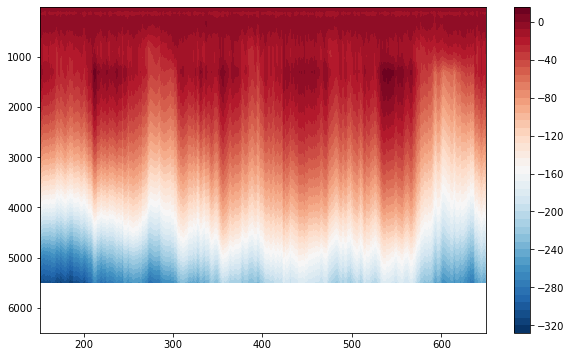

In [126]:
pltdata = ds_sigma15_new_avg - 1000
fig = plt.figure(figsize=(10,6))

pltdata0 = pltdata * dz

pltdata1 = pltdata0.cumsum(dim = 'lev') - pltdata * ds.lev_bnds[:,1]


im = plt.contourf(pltdata1.year, pltdata1.lev, pltdata1.transpose(), levels = 50, cmap=plt.cm.RdBu_r)#,  norm=colors.CenteredNorm()) #, norm=divnorm, 
plt.gca().invert_yaxis()
cbar = plt.colorbar(im)#, extend='none')

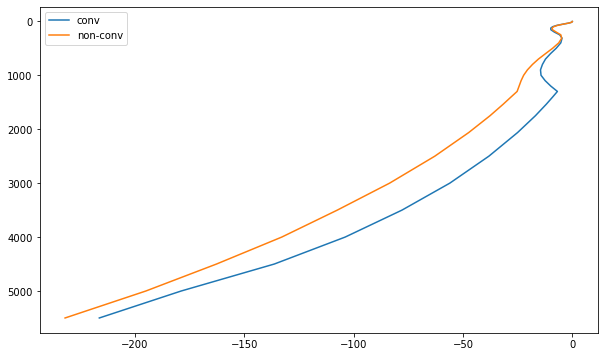

In [102]:
pltdata = ds_sigma15_new_avg - 1000
fig = plt.figure(figsize=(10,6))

pltdata0 = pltdata * dz
pltdata1 = pltdata0.cumsum(dim = 'lev') - pltdata * ds.lev_bnds[:,1]

pltdata_c = pltdata1.where(coninx_ws>1).mean('year')
pltdata_n = pltdata1.where(coninx_ws<-1).mean('year')
plt.plot(pltdata_c, pltdata_c.lev) #, norm=divnorm, 
plt.plot(pltdata_n, pltdata_n.lev)
plt.legend(['conv','non-conv'])
plt.gca().invert_yaxis()